<a href="https://colab.research.google.com/github/nortonvanz/ML_Pocket_Reference/blob/main/notebooks/Titanic_pipeline_c2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolução do Titanic utilizando CRISP-DM, seguindo o livro Machine Learning: Guia de Referência Rápica.

# Faça uma pergunta

Crie um modelo preditivo, que classifique se um indivíduo sobreviveu à catástrofe do Titanic (sim / não).

In [1]:
#Dataset e problema original no Kaggle: https://www.kaggle.com/competitions/titanic/data?select=train.csv

## Ciclo 2

In [2]:
#objetivo: melhorar a métrica acurácia obtida, ao subteter no Kaggle as predições do Ttitanic do ciclo 1: Kaggle score: 0.76555

In [4]:
# melhorias possíveis:

  #Balanceamento de classes: class_weight='balanced'
  #fazer feature selection
  #testar modelos lineares


### Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix # balanced_accuracy_score,  , precision_recall_curve

from xgboost                 import XGBClassifier

### Aux Functions:

In [ ]:
def standardize_cols(df):
  #converter tudo para minúsculo e com underline no lugar de espaços e pontos
  df.columns = df.columns.str.replace(' ','_').str.replace('.','_', regex=False).str.lower()
  return df

### Load Data

In [ ]:
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/train.csv
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/test.csv

df_raw_train = pd.read_csv('train.csv')
df_raw_test = pd.read_csv('test.csv')

train.csv.6         100%[===================>]  59.76K  --.-KB/s    in 0.001s  
test.csv.6          100%[===================>]  27.96K  --.-KB/s    in 0s      


In [ ]:
#padronizar nomes das colunas
df_raw_train = standardize_cols(df_raw_train)
df_raw_test = standardize_cols(df_raw_test)

In [ ]:
df_train = df_raw_train.copy()
df_train.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Split Datasets

In [ ]:
# Separação das variáveis independentes e dependente
X = df_train.drop(['survived'], axis=1)
y = df_train['survived'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# limpar vars
X=''
Y=''
df_train=''

# usa na EDA pro SV:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_train.head(2)

### Data Description

In [ ]:
#dimensões
print(f'Linhas: {X_train.shape[0]}')
print(f'Colunas: {X_train.shape[1]}')

Linhas: 668
Colunas: 11


In [ ]:
#tipos de dados
X_train.dtypes

passengerid      int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [ ]:
#check nulos
X_train.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age            132
sibsp            0
parch            0
ticket           0
fare             0
cabin          519
embarked         2
dtype: int64

### Data Preparation

In [ ]:
# inspect variations of each column
print(f"- Distinct values:\n{X_train.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{X_train.apply( lambda x: x.unique() ) } " )

- Distinct values:
passengerid    668
pclass           3
name           668
sex              2
age             83
sibsp            7
parch            7
ticket         529
fare           211
cabin          114
embarked         4
dtype: int64 

- Variations:
passengerid    [299, 885, 248, 479, 306, 317, 3, 406, 743, 26...
pclass                                                 [1, 3, 2]
name           [Saalfeld, Mr. Adolphe, Sutehall, Mr. Henry Jr...
sex                                               [male, female]
age            [nan, 25.0, 24.0, 22.0, 0.92, 26.0, 34.0, 21.0...
sibsp                                      [0, 1, 2, 4, 3, 8, 5]
parch                                      [0, 2, 1, 6, 4, 3, 5]
ticket         [19988, SOTON/OQ 392076, 250649, 350060, 11378...
fare           [30.5, 7.05, 14.5, 7.5208, 151.55, 26.0, 7.925...
cabin          [C106, nan, C22 C26, B57 B59 B63 B66, B28, C10...
embarked                                          [S, C, Q, nan]
dtype: object 


In [ ]:
# dropar, assumindo não serem relevantes neste ciclo: passengerid, name, ticket, cabin
X_train = X_train.drop(columns=['passengerid','name','ticket','cabin'])

#### Categorical Vars

In [ ]:
#cols que serão tratadas como categoricas, olhando a inspeção acima: pclass, sex, embarked

In [ ]:
# variáveis categóricas
cat_columns = ['pclass','sex','embarked']
#cat_columns = list(X.select_dtypes(include=['object']).columns)

In [ ]:
X_train[cat_columns].head(3)

,pclass,sex,embarked
298,1,male,S
884,3,male,S
247,2,female,S


In [ ]:
X_train[cat_columns].isna().sum()

pclass      0
sex         0
embarked    2
dtype: int64

In [ ]:
# pipeline variáveis cateǵoricas
  # SimpleImputer, resolvendo nulos de embarked
  # OneHotEncoder, gerando 1 coluna para cada categoria de cada uma das vas
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), #Substitui valores faltantes pela média, mediana, valor mais freq, ou valor constante.
                     ("ohe"        , OneHotEncoder(handle_unknown="ignore"))]) #Converte cada categoria em uma nova coluna. Aumenta a complexidade do dataset.


In [ ]:
cat_pipe

Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))])

#### Numerical Vars

In [ ]:
#cols que serão tratadas como numéricas, olhando a inspeção já realizada: age, sibsp, parch, fare

In [ ]:
# variáveis numéricas
num_columns = ['age','sibsp','parch','fare']
#num_columns  = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [ ]:
X_train[num_columns].head(3)

,age,sibsp,parch,fare
298,NaN,0,0,30.50
884,25.0,0,0,7.05
247,24.0,0,2,14.50


In [ ]:
X_train[num_columns].dtypes

age      float64
sibsp      int64
parch      int64
fare     float64
dtype: object

In [ ]:
X_train[num_columns].isna().sum()

age      132
sibsp      0
parch      0
fare       0
dtype: int64

In [ ]:
# pipeline variáveis numéricas
  #SimpleImputer, resolvendo missings de age
  #Robust e Standard Scaler  ->   #O pipeline gerencia quando vai usar o Robust ou o Standard?

num_pipe = Pipeline([("num_imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                     ("outliers"   , RobustScaler()), #Feature scaling p/ distribuição normal, com outliers.
                     ("scaler"     , StandardScaler())]) #Feature scaling p/ distribuição normal, sem outliers.


In [ ]:
num_pipe

Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median')),
                ('outliers', RobustScaler()), ('scaler', StandardScaler())])

#### Preprocessing

In [ ]:
# data preparation (aplica as transformações acima)
preprocessing = ColumnTransformer([("categorica", cat_pipe, cat_columns),
                                   ("numerica", num_pipe, num_columns)])

In [ ]:
preprocessing

ColumnTransformer(transformers=[('categorica',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['pclass', 'sex', 'embarked']),
                                ('numerica',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers', RobustScaler()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'sibsp', 'parch', 'fare'])])

### Feature Selection

In [ ]:
#Avançar com todas neste ciclo

### Machine Learning

In [ ]:
# pipeline para treinamento
pipe = Pipeline([("preprocessing", preprocessing),
                 ("xgb", XGBClassifier())])

In [ ]:
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   RobustScaler()),
                                                                  ('scaler',
                                                                   Standa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Fine Tuning

In [ ]:
# hiperparâmetros
xgb_hyperparams = {"xgb__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
                   "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                   "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
                   "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "xgb__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] }

# métricas
f1_macro          = make_scorer(f1_score, average="macro")
precision         = make_scorer(precision_score)
recall            = make_scorer(recall_score)
accuracy          = make_scorer(accuracy_score)

scoring_dict = {'f1_macro'          : f1_macro,
                'precision'         : precision,
                'recall'            : recall,
                'accuracy'          : accuracy}

In [ ]:
# Randomized Scearch Cross Validation
rscv = RandomizedSearchCV(estimator=pipe,
                          param_distributions=xgb_hyperparams,
                          n_iter = 10, #20
                          scoring = scoring_dict,
                          refit = 'f1_macro',
                          n_jobs = -1,
                          cv = 5,
                          random_state=42)

In [ ]:
# Resultado considerando a métrica principal (f1-score)
result = rscv.fit(X_train, y_train)

print(f'Os melhores parâmetros foram:\n{result.best_params_}')

print(f'\nA melhor média de f1-score foi: {result.best_score_}')

Os melhores parâmetros foram:
{'xgb__min_child_weight': 5, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}

A melhor média de f1-score foi: 0.819444217937782


In [ ]:
# Pipeline do melhor resultado
result.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   RobustScaler()),
                                                                  ('scaler',
                                                                   Standa...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [ ]:
# Resultado com todas as métricas observadas
df_result = pd.DataFrame(result.cv_results_)

# Selecionando apenas algumas das colunas
df_result[['rank_test_f1_macro',
           'mean_test_f1_macro',
           'std_test_f1_macro',
           'mean_test_precision',
           'std_test_precision',
           'mean_test_recall',
           'std_test_recall',
           'mean_test_accuracy',
           'std_test_accuracy']].sort_values('rank_test_f1_macro').head()

,rank_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy
0,1,0.819444,0.037590,0.823249,0.037098,0.719373,0.074918,0.835293,0.032547
3,2,0.815943,0.038736,0.816026,0.026890,0.719373,0.094724,0.832308,0.031729
2,3,0.811767,0.033210,0.811761,0.044076,0.711686,0.061968,0.827831,0.029171
7,4,0.810166,0.032791,0.819328,0.014869,0.699922,0.079692,0.827876,0.026081
9,5,0.809382,0.036695,0.812361,0.036093,0.703765,0.071588,0.826349,0.031432


### Test Data

In [ ]:
# Treino com o melhor pipeline
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

# Predição para dados nunca vistos
y_hat = model.predict(X_test)

# Métrica para dados não vistos pelo modelo
print(f'O f1-score foi: {f1_score(y_test, y_hat)}')
print(f'A precisão foi: {precision_score(y_test, y_hat)}')
print(f'O recall  foi:  {recall_score(y_test, y_hat)}')
print(f'A acurácia foi: {accuracy_score(y_test, y_hat)}')

O f1-score foi: 0.7865168539325842
A precisão foi: 0.7865168539325843
O recall  foi:  0.7865168539325843
A acurácia foi: 0.8295964125560538


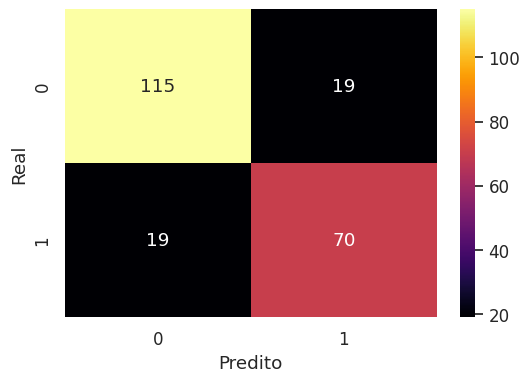

In [ ]:
# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (6, 4))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

### Retreino para submissão

In [ ]:
#retreinar o melhor modelo agora com todo o dataset de treino do Kaggle:

In [ ]:
#carregar dados originais
df_train = df_raw_train.copy()

# Separação das variáveis independentes e dependente
X = df_train.drop(['survived'], axis=1)
y = df_train['survived'].copy()

In [ ]:
# Retreino com o Pipeline do melhor resultado
pipe = result.best_estimator_
model = pipe.fit(X, y)

In [ ]:
#modelo final
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   RobustScaler()),
                                                                  ('scaler',
                                                                   Standa...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [ ]:
# predição em cima do dataset de teste Kaggle
y_pred = model.predict(df_raw_test)

In [ ]:
# padroniza no formato esperado pelo Kaggle
df_sub = df_raw_test[['passengerid','parch']]
df_sub = df_sub.rename(columns={"passengerid": "PassengerId", "parch": "Survived"})

In [ ]:
# atribui as previsões do modelo
df_sub['Survived'] = y_pred

In [ ]:
df_sub.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


In [ ]:
#salvar arquivo para submeter
df_sub.to_csv('part2_titanic_sub.csv', index=False)


In [ ]:
#Kaggle score: 0.76555 (levemente pior que da parte 1)

## Ciclo 2

In [ ]:
# melhorias
  #fazer feature selection
  #testar modelos lineares


In [ ]:
#duvidas
  #O pipeline gerencia quando vai usar o Robust ou o Standard?